In [63]:
%pip install kagglehub numpy pandas seaborn matplotlib scikit-learn


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [64]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [65]:
dataset_path = "../Cleaned_Breast_Cancer.csv"
df = pd.read_csv(dataset_path)

df.head()

,Age,Grade,Tumor Size,Survival Months,Node Positive Ratio,T Stage Encoded,M Stage Encoded,N Stage Encoded,Estrogen Status Encoded,Progesterone Status Encoded,Survival More Than 6 Years
0,68,3,4,60,0.041667,0.0,1,0.0,1,1,0
1,50,2,35,62,0.357143,1.0,1,1.0,1,1,0
2,58,2,63,75,0.500000,2.0,1,2.0,1,1,1
3,58,3,18,84,0.500000,0.0,1,0.0,1,1,1
4,47,3,41,50,0.333333,1.0,1,0.0,1,1,0


In [66]:
X = df.drop(columns=["Survival Months", "Survival More Than 6 Years"])
y = df["Survival More Than 6 Years"]

In [70]:
# @title LogReg from scratch (BCE)
class LogisticRegressionScratchBCE:
    def __init__(self, learning_rate=0.01, num_iterations=1000):
        self.learning_rate = learning_rate
        self.num_iterations = num_iterations
        self.w = None
        self.b = None
        self.losses = []

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def predict(self, X):
        z = np.dot(X, self.w) + self.b
        probs = self.sigmoid(z)

        # Return the class with the highest probability
        return np.where(probs >= 0.5, 1, 0)

    def initialize_weights(self, n_features):
        self.w = np.zeros((n_features, 1))  # Init with the same column number as feature
        self.b = 0

    def cost_function(self, h, y):
        m = len(y)
        # reg_term = (0.01 / (2 * m)) * np.sum(self.w ** 2)
        cost = -(1 / m) * np.sum(y * np.log(h + 1e-8) + (1 - y) * np.log(1 - h + 1e-8))

        return cost #+ reg_term

    def fit(self, X, y):
        X = np.array(X)
        y = np.array(y).reshape(-1, 1)  # Ensure y is a column vector
        print(X.shape, y.shape)
        m = len(y)
        n_features = X.shape[1]
        self.initialize_weights(n_features)

        for i in range(self.num_iterations):
            # Forward prop
            probs = self.predict(X)

            # Cost
            # error = -(1 / m) * np.sum(y * np.log(probs + 1e-8) + (1 - y) * np.log(1 - probs + 1e-8))
            error = self.cost_function(probs, y)
            self.losses.append(error)

            # Calculate the gradient of the error with respect to the weights
            gradient_w = (1 / m) * np.dot(X.T, (probs - y))
            gradient_b = (1 / m) * np.sum(probs - y)

            # Update the weights using the gradient and the learning rate
            self.w -= self.learning_rate * gradient_w
            self.b -= self.learning_rate * gradient_b

            # cost compute if more iteration (optional)
            if i % 100 == 0:
                print(f"Iteration {i}, Cost: {error}")

    def plot_loss(self):
        plt.figure(figsize=(8, 5))
        plt.plot(range(self.num_iterations), self.losses, label='MSE Loss')
        plt.xlabel("Iteration")
        plt.ylabel("Loss (MSE)")
        plt.title("Loss Curve: Logistic Regression (BCE)")
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

(4024, 9) (4024, 1)
Iteration 0, Cost: 9.114208583717485
Iteration 100, Cost: 9.288161334376083
Iteration 200, Cost: 9.301894446270182
Iteration 300, Cost: 9.315627558164282
Iteration 400, Cost: 9.311049854199583
Iteration 500, Cost: 9.315627558164282
Iteration 600, Cost: 9.311049854199583
Iteration 700, Cost: 9.315627558164282
Iteration 800, Cost: 9.311049854199583
Iteration 900, Cost: 9.324782966093682
Iteration 1000, Cost: 9.311049854199583
Iteration 1100, Cost: 9.311049854199583
Iteration 1200, Cost: 9.315627558164282
Iteration 1300, Cost: 9.315627558164282
Iteration 1400, Cost: 9.324782966093682
Iteration 1500, Cost: 9.324782966093682
Iteration 1600, Cost: 9.315627558164282
Iteration 1700, Cost: 9.315627558164282
Iteration 1800, Cost: 9.315627558164282
Iteration 1900, Cost: 9.311049854199583
Iteration 2000, Cost: 9.320205262128981
Iteration 2100, Cost: 9.306472150234882
Iteration 2200, Cost: 9.311049854199583
Iteration 2300, Cost: 9.311049854199583
Iteration 2400, Cost: 9.31104985

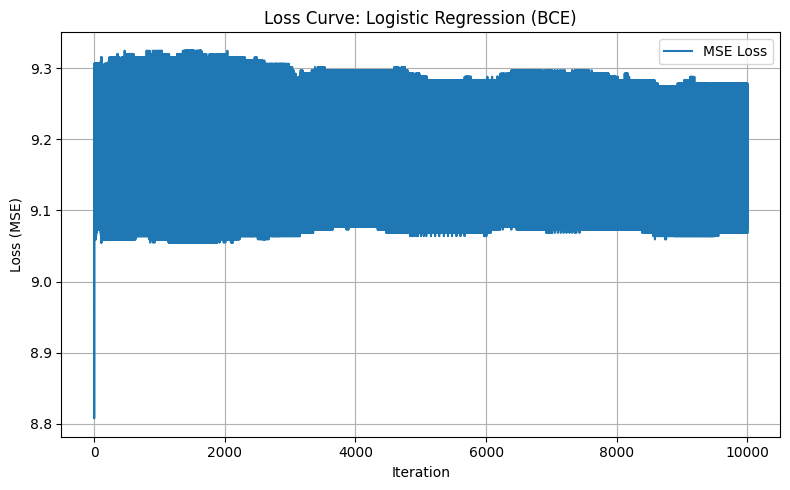

0.4967693836978131

In [76]:
# Import necessary libraries
from sklearn.metrics import accuracy_score

# Train Logistic Regression from scratch
BCEmodel_scratch = LogisticRegressionScratchBCE(learning_rate=1e-3, num_iterations=10000)
BCEmodel_scratch.fit(X, y)

# Predict and evaluate
BCE_pred_scratch = BCEmodel_scratch.predict(X)
BCEmodel_scratch.plot_loss()

score = accuracy_score(y, BCE_pred_scratch)
score

In [75]:
# Import necessary libraries
from sklearn.metrics import accuracy_score
score = accuracy_score(y, BCE_pred_scratch)
score

0.4967693836978131